In [3]:
from plotting import imshow
import torch
import numpy as np
import pickle
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import cv2

### Pickle functions for opening and saving

In [4]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def save_pickle(file, data):
    with open(file, 'wb') as fo:
        pickle.dump(data, fo)

In [5]:
# RGB training data load
train_set = unpickle('train')

# Image names 
filenames = [f.decode('utf-8') for f in train_set[b'filenames']]

# Getting the images
images_data = train_set[b'data'].copy() 


(50000, 1024)
(32, 32, 3)


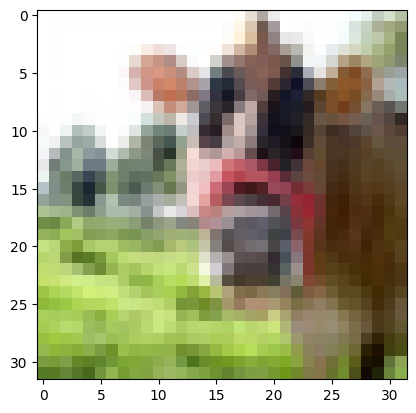

In [6]:
import matplotlib.pyplot as plt
red = train_set[b'data'][:,0:1024]
green = train_set[b'data'][:,1024:2048]
blue = train_set[b'data'][:,2048:3072]


print(red.shape)
red = red[0].reshape(32, 32, 1)
green = green[0].reshape(32, 32, 1)
blue = blue[0].reshape(32, 32, 1)

image = np.concatenate([red,green,blue], axis = 2)
print(image.shape)
plt.imshow(image)

### Data loading function to create tensors from the pickled data

In [8]:
class CustomDataset(Dataset):
    def __init__(self, filenames, images_data, transform=None):
        self.filenames = filenames # image name
        self.images_data = images_data # image data
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        # Creating image from the dataset
        img_data = self.images_data[idx]
        img = np.array(img_data, dtype=np.uint8)

        R_channel = img[0:1024].reshape(32, 32, 1)
        G_channel = img[1024:2048].reshape(32, 32, 1)
        B_channel = img[2048:].reshape(32, 32, 1)

        image = np.concatenate([R_channel,G_channel,B_channel], axis = 2)
    
        if self.transform:
            image = self.transform(image)

        return image, self.filenames[idx]

# Normalization and transforming to a tensor
transform = transforms.Compose([
    transforms.ToTensor(),
])

### Functions for color scale conversions

In [9]:
# Input tensor(C,H,W) -> output tensor(H,W,C)
def rgb_yuv(array):
    new_array = array.permute(1,2, 0).numpy().copy()
    return torch.Tensor(cv2.cvtColor(new_array, cv2.COLOR_RGB2YUV))

# Input tensor(H,W,C) -> output tensor(C,H,W)
def yuv_rgb(array):
    new_array = array.numpy().copy()
    new_array = cv2.cvtColor(new_array, cv2.COLOR_YUV2RGB)
    return torch.tensor((new_array*255).astype(np.uint8)).permute(2, 0, 1)

### Creating the YUV scaled images

In [10]:
# Loading the RGB images
dataset = CustomDataset(filenames=filenames, images_data=images_data,transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle = False)

In [11]:
all_yuv = []
for batch in train_loader:
    image_tensor, filename = batch  # Extract data from the batch
    for idx, image_rgb in enumerate(image_tensor):

        #print(torch.cat([R_channel.unsqueeze(0),G_channel,B_channel],dim=0).size())
        img_yuv = cv2.cvtColor(image_rgb.permute(1,2,0).numpy(), cv2.COLOR_RGB2YUV)
        
        i0 = img_yuv[:,:,0].reshape((1,1024))
        i1= img_yuv[:, :,1].reshape((1,1024))
        i2= img_yuv[:, :,2].reshape((1,1024))
        array_yuv = np.concatenate([i0,i1,i2],axis=0)
        
        # Renormalizing and transforming to numpy array
        all_yuv.append((array_yuv*255).astype("uint8")) 
        
    

In [12]:
# Reshaping to match b'data' style
all_yuv_array = np.array(all_yuv).reshape(images_data.shape)

# Create new dictionary with the same structure
yuv_train_set = train_set.copy()

yuv_train_set[b'data'] = all_yuv_array
save_pickle('yuv_train', yuv_train_set)

### Loading YUV image dataset

In [13]:
yuv_train_set = unpickle('yuv_train')

yuv_images_data = yuv_train_set[b'data']

yuv_dataset = CustomDataset(filenames=filenames, images_data=yuv_images_data, transform=transform)
yuv_train_loader = DataLoader(yuv_dataset, batch_size=32, shuffle = False)

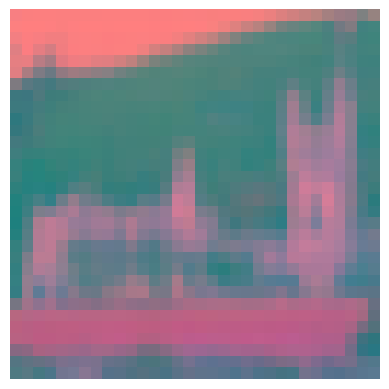

Filename: balmoral_castle_s_000361.png


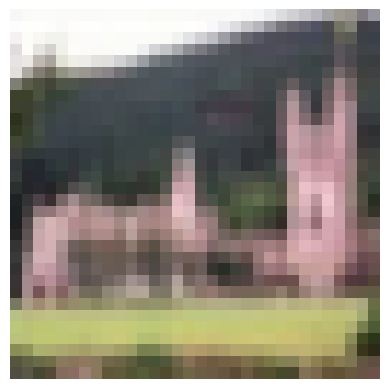

In [14]:
for batch in yuv_train_loader:
    image_tensor, filename = batch  # Extract data from the batch

    image_yuv = image_tensor[31]  # Frist image of the batch (YUV)

    # Need to resize first
    imshow(image_yuv)
    rgb_output = yuv_rgb(image_yuv.permute(1,2,0))

    print(f"Filename: {filename[31]}")

    imshow(rgb_output) 
    break